### Import libraries

In [1]:
from matplotlib import pyplot as plt

import numpy as np

from iminuit import Minuit

from functools import partial
from numba import njit

from joblib import Parallel, delayed

import os, sys
sys.path.append(os.path.abspath('..'))

import constants, functions

### First Chi2 estimation for window

In [2]:
import pandas as pd
data_bao = pd.read_csv("../../data/DESIDR2/alpha_data.dat", sep=';', header=0)

z_data_bao = data_bao['zeff']
Dmrd_data = data_bao['DM/rd']
Dmrd_err = data_bao['DM/rd_err']

In [50]:
@njit
def H_LCDM(z, H0, omega_m):
    return H0 * np.sqrt(omega_m * (1+z)**3 + (1 - omega_m))

@njit
def integral_trapezoid(func, a, b, N, H0, omega_m):
    h = (b - a) / N
    result = 0.5 * (func(a, H0, omega_m) + func(b, H0, omega_m))
    for i in range(1, N):
        result += func(a + i * h, H0, omega_m)
    result *= h
    return result

@njit
def inv_H_LCDM(z, H0, omega_m):
    return 1.0 / H_LCDM(z, H0, omega_m)

@njit
def Dmrd(z, omega_m, rd, H0, c):
    integral = integral_trapezoid(inv_H_LCDM, 0.0, z, 100, H0, omega_m)
    return c * integral / rd

@njit
def Dmrd_array(z_array, omega_m, rd, H0, c):
    result = np.empty_like(z_array)
    for i in range(z_array.size):
        result[i] = Dmrd(z_array[i], omega_m, rd, H0, c)
    return result

@njit
def chi2_bao(z_data, dmrd_data, dmrd_err, c, omega, rd, H0):
    """ Returns chi2 value for a given omega, sigma, gamma.

    Args:
        z_data
        fs8_data: constants.fs8_data.values
        fs8_err_plus
        fs8_err_minus
        omega (float)
        sigma (float)
        gamma (float)

    Returns:
        float: chi2
    """
    model = Dmrd_array(z_data, omega, rd, H0, c)

    residuals = (model - dmrd_data) / dmrd_err
    return np.sum(residuals**2)

### REDOUANE
def trans_Da_rd(z, x):
    return (1/(1+z))*(x)

def f(z,H0,omega_m,w):
    a  = (H0*np.sqrt(omega_m*math.pow((1+z),3)+(1-omega_m)*(math.pow((1+z),3*(1+w)))))
    if a == 0:
        print("a = ",0)
    return 1/a

def model_Da_rd(z, H0, w, omega_m0, rd):
    I,err = quad(f,0,z,args = (H0,omega_m0,w))
    return (c*I)/(rd)

def Chi2DESI(H0, omega_m0, rd, z_DESI, Dm_rd, Dm_rd_err, w=-5):
    Da_rd = trans_Da_rd(z_DESI,Dm_rd)
    Da_rd_err = trans_Da_rd(z_DESI,Dm_rd_err)
    chi2 = 0
    for i in range(len(z_DESI)):
        chi2 += ((Dmrd(z_DESI[i], H0, w, omega_m0, rd)-Da_rd[i])/Da_rd_err[i])**2
        # chi2 += ((model_Da_rd(z_DESI[i],H0,w,omega_m0,rd)-Da_rd[i])/Da_rd_err[i])**2
    return chi2
### REDOUANE

# @njit
def chi2_rsd_bao(z_data_rsd, z_data_bao, fs8_data, fs8_err_plus, fs8_err_minus, dmrd_data, dmrd_err, c, omega, sigma, gamma, rd, H0):
    # return functions.chi2_rsd(z_data_rsd, fs8_data, fs8_err_plus, fs8_err_minus, omega, sigma, gamma)
    return Chi2DESI(H0, omega, rd, z_data_bao, dmrd_data, dmrd_err)
    # return chi2_bao(z_data_bao, dmrd_data, dmrd_err, c, omega, rd, H0)
    # return functions.chi2_rsd(z_data_rsd, fs8_data, fs8_err_plus, fs8_err_minus, omega, sigma, gamma) + Chi2DESI(H0, omega, rd, z_data_bao, dmrd_data, dmrd_err)
    # return functions.chi2_rsd(z_data_rsd, fs8_data, fs8_err_plus, fs8_err_minus, omega, sigma, gamma) + chi2_bao(z_data_bao, dmrd_data, dmrd_err, c, omega, rd, H0)

z_data_bao = np.asarray(z_data_bao)
Dmrd_data = np.asarray(Dmrd_data)
Dmrd_err = np.asarray(Dmrd_err)

z_data_rsd = np.asarray(constants.z_data)
fs8_data = np.asarray(constants.fs8_data)
fs8_err_plus = np.asarray(constants.fs8_err_plus)
fs8_err_minus = np.asarray(constants.fs8_err_minus)
c = constants.C

chi2_func = partial(
    chi2_rsd_bao,
    z_data_rsd,
    z_data_bao,
    fs8_data,
    fs8_err_plus,
    fs8_err_minus,
    Dmrd_data,
    Dmrd_err,
    c
)

In [19]:
N = 100

n_om = N
n_H0 = N
n_rd = N
n_s8 = N
n_gamma = N

H0_min = 50
H0_max = 100

rd_min = 100
rd_max = 200

om_min = .05
om_max = 1

s8_min = 0.4
s8_max = 1.2

gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))
rd_vals = np.asarray(np.linspace(rd_min, rd_max, n_rd))
H0_vals = np.asarray(np.linspace(H0_min, H0_max, n_H0))

In [51]:
minimizer = Minuit(chi2_func, omega=0.315, sigma=0.811, gamma=0.55, rd=147, H0=73.4)

minimizer.limits["omega"] = (om_min, om_max)
minimizer.limits["sigma"] = (s8_min,s8_max)
minimizer.limits["gamma"] = (gamma_min,gamma_max)
minimizer.limits["rd"] = (rd_min, rd_max)
minimizer.limits["H0"] = (H0_min, H0_max)

result = minimizer.migrad()

print(f"\nRésultats du fit :")
print(f"Chi2 = {minimizer.fval:.2f} \n")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega']:.3f} ± {minimizer.errors['omega']:.4f}")
print(f"rd = {minimizer.values['rd']:.3f} ± {minimizer.errors['rd']:.4f}")
print(f"H0 = {minimizer.values['H0']:.3f} ± {minimizer.errors['H0']:.3f}\n")

print(result)


Résultats du fit :
Chi2 = 95643.21 

Paramètres estimés :
Ωm = 1.000 ± 0.0000
rd = 100.000 ± 0.0036
H0 = 100.000 ± 0.008

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.564e+04                  │              Nfcn = 132              │
│ EDM = 1.55e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────

### Calculations

In [44]:
from time import time
from scipy.integrate import quad
import math

def chi2_om_s8_func(omega, sigma, gamma_min, gamma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, sigma=sigma, gamma=0.55, rd = 147.05, H0 = 73.4)
    minimizer.fixed["omega"] = True
    minimizer.fixed["sigma"] = True
    minimizer.limits["gamma"] = (gamma_min, gamma_max)
    minimizer.fixed["H0"] = True
    minimizer.fixed["rd"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_om_gamma_func(omega, gamma, sigma_min, sigma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, gamma=gamma, sigma=0.7, rd = 147.05, H0 = 73.4)
    minimizer.fixed["omega"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["sigma"] = (sigma_min, sigma_max)
    minimizer.fixed["H0"] = True
    minimizer.fixed["rd"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_s8_gamma_func(sigma, gamma, omega_min, omega_max, chi2_func):
    minimizer = Minuit(chi2_func, sigma=sigma, gamma=gamma, omega=0.3, rd = 147.05, H0 = 73.4)
    minimizer.fixed["sigma"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["omega"] = (omega_min, omega_max)
    minimizer.fixed["H0"] = True
    minimizer.fixed["rd"] = True
    minimizer.migrad()
    return minimizer.fval

t = time()
chi2_om_sig8 = Parallel(n_jobs=-1)(delayed(chi2_om_s8_func)(omega, sigma, gamma_min, gamma_max, chi2_func) for omega in omega_vals for sigma in sigma_vals)
chi2_grid1 = np.array(chi2_om_sig8).reshape(n_om, n_s8)
# np.savez("../output/chi2_SN1a/chi2_grid1.npz", grid1=chi2_grid1)
t = time() - t
print("chi2_grid 1 calculated in", int(t//60), "min", round(t%60,1), "s.")

# t = time()
# chi2_om_gamma = Parallel(n_jobs=-1)(delayed(chi2_om_gamma_func)(omega, gamma, s8_min, s8_max, chi2_func) for omega in omega_vals for gamma in gamma_vals)
# chi2_grid2 = np.array(chi2_om_gamma).reshape(n_om, n_gamma)
# # np.savez("../output/chi2_SN1a/chi2_grid2.npz", grid2=chi2_grid2)
# t = time() - t
# print("chi2_grid 2 calculated in", int(t//60), "min", round(t%60,1), "s.")

# t = time()
# chi2_s8_gamma = Parallel(n_jobs=-1)(delayed(chi2_s8_gamma_func)(sigma, gamma, om_min, om_max, chi2_func) for sigma in sigma_vals for gamma in gamma_vals)
# chi2_grid3 = np.array(chi2_s8_gamma).reshape(n_s8, n_gamma)
# # np.savez("../output/chi2_SN1a/chi2_grid3.npz", grid3=chi2_grid3)
# t = time() - t
# print("chi2_grid 3 calculated in", int(t//60), "min", round(t%60,1), "s.")

chi2_grid 1 calculated in 0 min 11.7 s.


### Plot

(0.4, 0.2035353535353535)
Incertitude $\sigma_8$ : xmin = 0.40, xmax = 1.20 : (+0.0, -0.8)
Incertitude $\Omega_m$ : ymin = 0.20, ymax = 0.21 : (+0.0, -0.01)

(0.30808080808080807, 0.2035353535353535)
Incertitude $\gamma$ : xmin = 0.18, xmax = 0.41 : (+0.13, -0.1)
Incertitude $\Omega_m$ : ymin = 0.20, ymax = 0.21 : (+0.0, -0.01)

(0.30808080808080807, 0.7070707070707071)
Incertitude $\gamma$ : xmin = 0.18, xmax = 0.41 : (+0.13, -0.1)
Incertitude $\sigma_8$ : ymin = 0.63, ymax = 0.77 : (+0.07, -0.06)



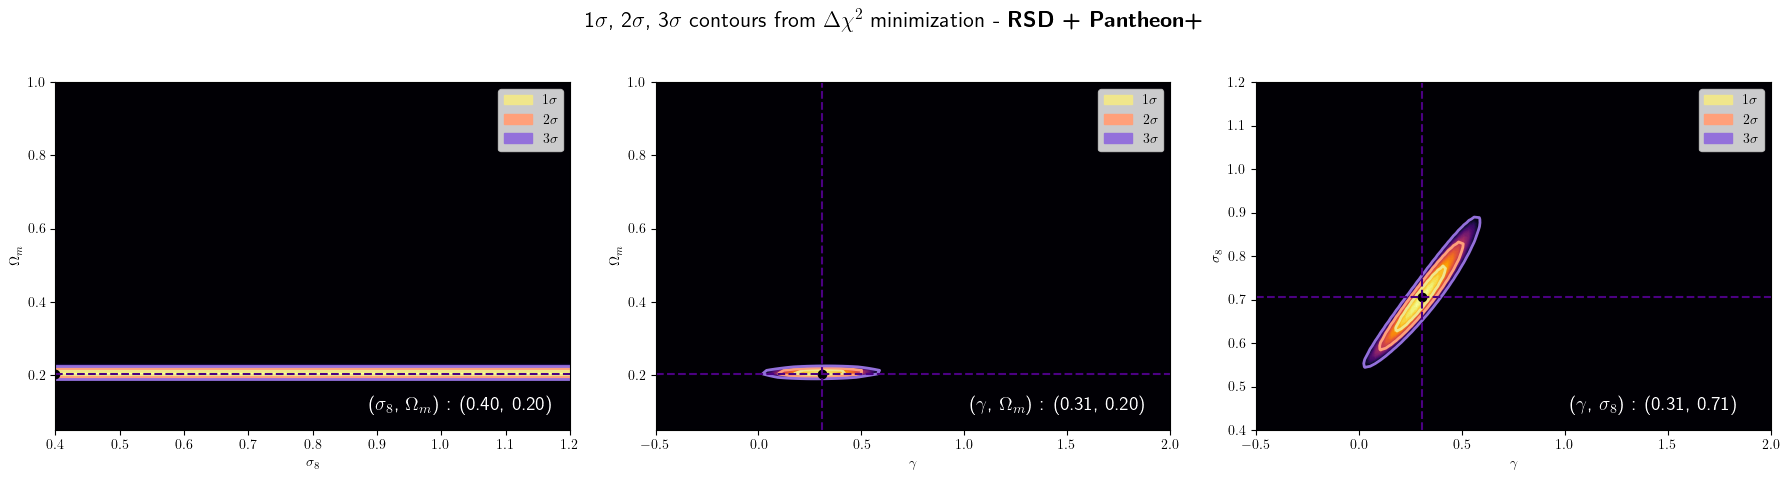

In [45]:
from matplotlib.patches import Patch
def display_all_chi2(chi2_grids, axes):
    levels = [2.3, 6.17, 11.8]
    colors = ['khaki', 'lightsalmon', 'mediumpurple']

    axes_titles = [
        (r'$\sigma_8$', r'$\Omega_m$', 0),
        (r'$\gamma$', r'$\Omega_m$', 1),
        (r'$\gamma$', r'$\sigma_8$', 2)
    ]

    for ax, (xlabel, ylabel, axis) in zip(axes, axes_titles):
        chi2_grid = chi2_grids[axis]
        
        sigma_vals = np.asarray(np.linspace(s8_min, s8_max, chi2_grid.shape[0]))
        omega_vals = np.asarray(np.linspace(om_min, om_max, chi2_grid.shape[0]))
        gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, chi2_grid.shape[0]))

        if axis == 0:
            X, Y = np.meshgrid(sigma_vals, omega_vals)
        elif axis == 1:
            X, Y = np.meshgrid(gamma_vals, omega_vals)
        elif axis == 2:
            X, Y = np.meshgrid(gamma_vals, sigma_vals)

        chi2_min = np.min(chi2_grid)
        delta_chi2 = chi2_grid - chi2_min

        delta_chi2_clipped = np.clip(delta_chi2, a_min=None, a_max=levels[2])
        
        cf = ax.contourf(X, Y, delta_chi2_clipped, levels=100, cmap='inferno_r')
        
        for level, color in zip(levels, colors):
            cs = ax.contour(X, Y, delta_chi2, levels=[level], colors=[color], linewidths=2)

            # Get incertitude
            if level == 2.3:
                mask = delta_chi2 <= level

                x_coords = X[mask]
                y_coords = Y[mask]

                xmin, xmax = np.min(x_coords), np.max(x_coords)
                ymin, ymax = np.min(y_coords), np.max(y_coords)

        legend_handles = [
            Patch(color='khaki', label=r'$1\sigma$'),
            Patch(color='lightsalmon', label=r'$2\sigma$'),
            Patch(color='mediumpurple', label=r'$3\sigma$')
        ]
        ax.legend(handles=legend_handles, loc='upper right')

        min_idx = np.unravel_index(np.argmin(delta_chi2), delta_chi2.shape)
        x_min = X[min_idx]
        y_min = Y[min_idx]
        ax.plot(x_min, y_min, 'ko', label='Best-fit')
        ax.axhline(y_min, color='indigo', linestyle='--')
        ax.axvline(x_min, color='indigo', linestyle='--')

        print((x_min, y_min))
        print(f"Incertitude {axes_titles[axis][0]} : xmin = {xmin:.2f}, xmax = {xmax:.2f} : (+{round(x_min - xmin, 2)}, -{round(xmax - x_min, 2)})")
        print(f"Incertitude {axes_titles[axis][1]} : ymin = {ymin:.2f}, ymax = {ymax:.2f} : (+{round(y_min - ymin, 2)}, -{round(ymax - y_min, 2)})\n")

        latex_text = fr"({xlabel}, {ylabel}) : ({x_min:.2f}, {y_min:.2f})"
        ax.text(0.61, 0.1, latex_text, transform=ax.transAxes, color="white", fontsize=14,
                verticalalignment='top', horizontalalignment='left')

        ax.set_xlabel(axes_titles[axis][0])
        ax.set_ylabel(axes_titles[axis][1])

        ax.set_facecolor('black')

        # if axis == 0:
        #     ax.set_xlim([0.5, 1.03])
        #     ax.set_ylim([0.25, 0.47])
        # elif axis == 1:
        #     ax.set_xlim([-.1, 1.3])
        #     ax.set_ylim([0.23, 0.5])
        # elif axis == 2:
        #     ax.set_xlim([-0.1, 1.3])
        #     ax.set_ylim([0.5, 1.1])


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.rcParams.update({
    "text.usetex": True
})
fig.suptitle(r"1$\sigma$, 2$\sigma$, 3$\sigma$ contours from $\Delta \chi^2$ minimization - $\textbf{RSD + Pantheon+}$", fontsize=16)
display_all_chi2([chi2_grid1, chi2_grid2, chi2_grid3], axes)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()